In this notebook, we're going to generate some synthetic binary classification data and show how to train supervised cadre models (SCM) on it. We'll train a model with the default parameters, and then we'll show how we can use cross-validation for hyperparameter tuning to get better performance.

THIS NOTEBOOK IS INCOMPLETE

In [1]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.insert(0, '../cadreModels')

from classificationBinary import binaryCadreModel
from sklearn.datasets import make_classification
from scipy.stats import zscore, zmap

from sklearn.model_selection import train_test_split

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
sns.set_style('darkgrid')

Generate data with the `sklearn.datasets.make_classification` function. Bind `X` and `y` into a `pd.DataFrame`.

In [11]:
X, y = make_classification(n_samples=50000, random_state=2125615, n_clusters_per_class=10, 
                           n_features=50, n_informative=25, n_repeated=15)

data = pd.DataFrame(X)
data.columns = ['f'+str(p) for p in data.columns]
data = data.assign(target=y)
features = data.columns[data.columns != 'target']

In [12]:
data.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f41,f42,f43,f44,f45,f46,f47,f48,f49,target
0,-0.562447,-4.496746,-4.496746,0.523007,5.937111,0.628727,0.261670,-3.003903,0.523007,2.877445,...,2.169409,4.228746,-2.491846,0.389091,-1.462236,-1.188389,0.389091,5.371964,0.523007,1
1,-0.466490,1.704545,1.704545,1.158476,-0.013365,0.751370,-2.209397,2.166053,1.158476,0.362309,...,-1.412764,0.007301,-4.074863,3.412430,-1.229256,-3.037757,3.412430,-5.643174,1.158476,1
2,0.950077,3.122326,3.122326,-0.534232,-3.825865,-1.757176,1.554950,0.632377,-0.534232,3.675752,...,-1.114574,0.188603,2.145846,3.929885,-7.317242,-4.200953,3.929885,-4.407239,-0.534232,0
3,0.896450,1.962297,1.962297,5.707130,-3.910068,1.387582,3.167782,5.575011,5.707130,-0.543254,...,1.480521,4.057712,0.410260,2.630305,7.187664,3.307076,2.630305,2.483412,5.707130,0
4,-0.032346,2.897824,2.897824,-0.938040,1.600827,1.681539,2.033267,-1.647245,-0.938040,0.065656,...,2.976090,6.443671,1.234381,1.099088,7.176274,-2.604756,1.099088,-1.910424,-0.938040,1


Since the features are continuous, we should standardize them.

In [13]:
D_tr, D_va = train_test_split(data, test_size=0.2, random_state=313616)

D_va[features] = zmap(D_va[features], D_tr[features])
D_tr[features] = zscore(D_tr[features])

/home/newa/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/newa/.conda/envs/my_root/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/newa/.conda/envs/my_root/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

A `binaryCadreModel`'s initialization function takes the following arguments and default values:

* `M=2` -- number of cadres in model
* `gamma=10.` -- cadre-assignment sharpness
* `lambda_d=0.01` -- regularization strength for cadre-assignment weight parameter `d`
* `lambda_W=0.01` -- regularization strength for classification-weight parameter `W`
* `alpha_d=0.9` -- elastic net mixing weight for cadre-assignment weight parameter `d`
* `alpha_W=0.9` -- elastic net mixing with for classification-weight parameter `W`
* `Tmax=10000` -- maximum number of SGD steps to take
* `record=100` -- during training, how often goodness-of-fit metrics should be evaluated on the data
* `eta=2e-3` -- initial stepsize / learning rate
* `Nba=64` -- minibatch size
* `eps=1e-3` -- convergence tolerance
* `termination_metric='ROC_AUC'` -- training terminated if the difference between the most recent `termination_metric` value and the second most recent `termination_metric` is less than `eps`

Once you initialize a `binaryCadreModel`, you apply the `fit` method to train it. This method takes the following arguments and default values:

* `data` -- `pd.DataFrame` of training data
* `targetCol` -- string column-name of target feature in `data`
* `cadreFts=None` -- `pd.Index` of column-names used for cadre-assignment
* `predictFts=None` -- `pd.Index` of column-names used for target-prediction
* `dataVa=None` -- optional `pd.DataFrame` of validation data 
* `seed=16162` -- seed for parameter initialization and minibatch generation
* `store=False` -- whether or not copies `data` and `dataVa` should be added as attributes of the `binaryCadreModel`
* `progress=False` -- whether or not goodness-of-fit metrics should be printed during training

Other attributes of the `binaryCadreModel` include:

* `W` -- matrix of cadre-specific classification weights
* `W0` -- vector of cadre-specific classification biases
* `C` -- matrix of cadre centers
* `d` -- vector of cadre-assignments weights
* `metrics` -- a `dict` with `'training'` and `'validation'` as keys. Each item is a `pd.DataFrame` of goodness-of-fit metrics evaluated during training. Metrics include loss, accuracy, ROC AUC, and precision-recall (PR) AUC
* `time` -- list of computer-time values it took for each SGD step to be evaluated
* `proportions` -- during training, the proportion of the training data assigned to each cadre is recorded. This is a `pd.DataFrame` of those proportions, which lets you see if cadre assignments have converged to a stable distribution.

In [31]:
scm = binaryCadreModel(Tmax=15001, record=50, eps=1e-4, lambda_W=1e-3, lambda_d=1e-3, M=10)
scm.fit(D_tr, 'target', features, features, D_va, progress=True)

numbers being printed: SGD iteration, training loss, training accuracy, validation loss, validation accuracy, time
0
50 1.288237 0.513625 1.2925402 0.5142 0.14185380935668945
100 1.1990836 0.532425 1.2039498 0.5328 9.189023494720459
150 1.1659858 0.54215 1.1708246 0.541 17.90015459060669
200 1.1448362 0.5495 1.149663 0.549 26.470364809036255
250 1.1292944 0.55415 1.1338947 0.5566 35.697067737579346
300 1.1158237 0.55935 1.1206491 0.5601 44.20123219490051
350 1.1042295 0.56345 1.1093773 0.5639 52.90781283378601
400 1.0942712 0.567925 1.0994487 0.5675 61.72323799133301
450 1.0864356 0.57165 1.091562 0.5711 70.78901958465576
500 1.0792034 0.57505 1.0843984 0.574 79.52588558197021
550 1.0727972 0.578875 1.0780281 0.5766 88.73291277885437
600 1.0668609 0.5817 1.0722369 0.5783 97.6637442111969
650 1.0614837 0.5845 1.0667832 0.5796 106.30814409255981
700 1.0566071 0.5866 1.0619483 0.5833 114.96048521995544
750 1.052408 0.5897 1.0577037 0.5864 124.28458523750305
800 1.0483716 0.592525 1.053685

6950 0.9573653 0.6871 0.96078324 0.6753 1220.772142648697
7000 0.9572366 0.687025 0.96065605 0.6757 1229.5448822975159
7050 0.9571382 0.6876 0.9605405 0.6763 1237.9231631755829
7100 0.956996 0.687175 0.9603725 0.6763 1247.3230185508728
7150 0.9568698 0.68775 0.9602403 0.6756 1256.0553977489471
7200 0.9567338 0.6879 0.9601177 0.6764 1264.8121948242188
7250 0.9566101 0.68795 0.960002 0.6758 1273.352855205536
7300 0.95647854 0.688375 0.9598349 0.6756 1282.426216840744
7350 0.95629835 0.6884 0.959671 0.6767 1291.281670331955
7400 0.9561332 0.68865 0.9595088 0.6762 1300.2104437351227
7450 0.9560284 0.688525 0.9593906 0.6766 1309.1972057819366
7500 0.955919 0.688825 0.9592451 0.6767 1318.74321103096
7550 0.9557954 0.6888 0.9591123 0.677 1327.9070074558258
7600 0.9556738 0.689025 0.9589948 0.6769 1336.4240856170654
7650 0.9555502 0.68925 0.9588586 0.6772 1345.8544471263885
7700 0.95542735 0.689325 0.9587213 0.6771 1355.1702570915222
7750 0.9553195 0.689825 0.9586153 0.6775 1364.1958582401276


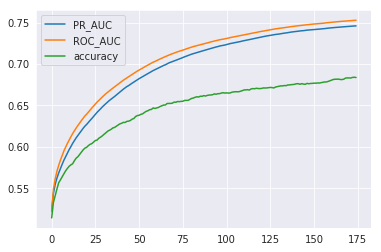

In [36]:
scm.metrics['validation'].drop('loss', axis=1).plot()

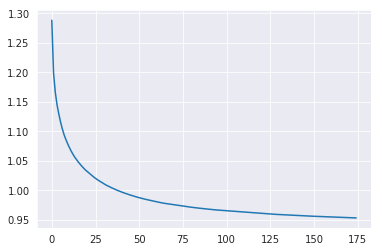

In [33]:
scm.metrics['training']['loss'].plot()

In [32]:
scm.scoreMetrics(D_va)

,PR_AUC,ROC_AUC,accuracy,loss
0,0.746091,0.752956,0.6838,0.667276


In [37]:
scm.entropy(D_va)

array([1.43225427, 1.06506241, 1.64184336, 1.02734326, 1.06241517,
       0.85694576, 0.9344213 , 1.22366534, 1.18158795, 1.03652339])

In [34]:
f, l, G, m, l = scm.predictFull(D_va)

In [35]:
pd.Series(m).value_counts()

5    1420
6    1410
1    1247
3    1213
4    1111
9    1024
7     912
8     769
0     506
2     388
dtype: int64